# Data Preparation

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from matplotlib import pyplot

In [2]:
%matplotlib inline
pd.options.display.float_format ='{:,.3f}'.format
%config InlineBackend.figure_format = 'svg' 

In [3]:
train_data_df = pd.read_csv('data/train.csv')
train_data_df

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,"482,087.000",NaN,0.000,11.000,26.300,"685,960.000",1.000,NaN,1.000,debt consolidation,Short Term,"99,999,999.000","47,386.000","7,914.000",749.000,0
1,Own Home,"1,025,487.000",10+ years,0.000,15.000,15.300,"1,181,730.000",0.000,NaN,0.000,debt consolidation,Long Term,"264,968.000","394,972.000","18,373.000",737.000,1
2,Home Mortgage,"751,412.000",8 years,0.000,11.000,35.000,"1,182,434.000",0.000,NaN,0.000,debt consolidation,Short Term,"99,999,999.000","308,389.000","13,651.000",742.000,0
3,Own Home,"805,068.000",6 years,0.000,8.000,22.500,"147,400.000",1.000,NaN,1.000,debt consolidation,Short Term,"121,396.000","95,855.000","11,338.000",694.000,0
4,Rent,"776,264.000",8 years,0.000,13.000,13.600,"385,836.000",1.000,NaN,0.000,debt consolidation,Short Term,"125,840.000","93,309.000","7,180.000",719.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,"402,192.000",< 1 year,0.000,3.000,8.500,"107,866.000",0.000,NaN,0.000,other,Short Term,"129,360.000","73,492.000","1,900.000",697.000,0
7496,Home Mortgage,"1,533,984.000",1 year,0.000,10.000,26.500,"686,312.000",0.000,43.000,0.000,debt consolidation,Long Term,"444,048.000","456,399.000","12,783.000","7,410.000",1
7497,Rent,"1,878,910.000",6 years,0.000,12.000,32.100,"1,778,920.000",0.000,NaN,0.000,buy a car,Short Term,"99,999,999.000","477,812.000","12,479.000",748.000,0
7498,Home Mortgage,NaN,NaN,0.000,21.000,26.500,"1,141,250.000",0.000,NaN,0.000,debt consolidation,Short Term,"615,274.000","476,064.000","37,118.000",NaN,0


Data preparation functions.

In [4]:
def prepare_data_v1(data):
    prepared_data = pd.get_dummies(data, prefix=['ho', 'p'], columns = ['Home Ownership', 'Purpose'], drop_first=False)
    transform_dict = {'< 1 year':0.5, '10+ years':10, '2 years':2, '3 years':3, '5 years':5, '1 year':1, '4 years':4, '6 years':6, '7 years':7, '8 years':8, '9 years':9}
    prepared_data['Years in current job'] = data['Years in current job'].replace(transform_dict, None)
    prepared_data['Term'] = data['Term'].replace({'Long Term':1, 'Short Term':0}, None)
    prepared_data['Current Loan Amount'] = data['Current Loan Amount'].replace(99999999, np.nan)
    prepared_data['Credit Score'] = data['Credit Score'].apply(lambda x: x/10 if (x > 1000) else x)
    return prepared_data

def prepare_data_v2(data):
    prepared_data = pd.get_dummies(data, prefix=['ho', 'p'], columns = ['Home Ownership', 'Purpose'], drop_first=False)  
    transform_dict = {'< 1 year':0, '10+ years':1, '2 years':0, '3 years':0, '5 years':0, '1 year':0, '4 years':0, '6 years':0, '7 years':0, '8 years':0, '9 years':0}
    prepared_data['Years in current job'] = data['Years in current job'].replace(transform_dict, None)
    prepared_data['Term'] = data['Term'].replace({'Long Term':1, 'Short Term':0}, None)
    prepared_data['Current Loan Amount'] = data['Current Loan Amount'].replace(99999999, np.nan)
    prepared_data['Credit Score'] = data['Credit Score'].apply(lambda x: x/10 if (x > 1000) else x)
    prepared_data['Tax Liens'] = data['Tax Liens'].apply(lambda x: 0 if (x == 0) else 1)
    prepared_data['Number of Credit Problems'] = data['Number of Credit Problems'].apply(lambda x: 0 if (x == 0) else 1)
    prepared_data['Bankruptcies'] = data['Bankruptcies'].apply(lambda x: 0 if x == 0 else 1)
    threshold = 10000000
    prepared_data['Maximum Open Credit'] = data['Maximum Open Credit'].apply(lambda x: threshold if (x > threshold) else x)
    return prepared_data

def prepare_data_v3(data):
    prepared_data = pd.get_dummies(data, prefix=['ho', 'p'], columns = ['Home Ownership', 'Purpose'], drop_first=False)
    transform_dict = {'< 1 year':0.1, '10+ years':10, '2 years':2, '3 years':3, '5 years':5, '1 year':1, '4 years':4, '6 years':6, '7 years':7, '8 years':8, '9 years':9}
    prepared_data['Years in current job'] = data['Years in current job'].replace(transform_dict, None)
    prepared_data['Term'] = data['Term'].replace({'Long Term':1, 'Short Term':0}, None)
    prepared_data['Current Loan Amount'] = data['Current Loan Amount'].replace(99999999, np.nan)
    prepared_data['Credit Score'] = data['Credit Score'].apply(lambda x: x/10 if (x > 1000) else x)  
    return prepared_data

def fill_na_v1(data):
    prepared_data = data
    prepared_data['Annual Income'] = data['Annual Income'].fillna(data['Annual Income'].mean())
    prepared_data['Current Loan Amount'] = data['Current Loan Amount'].fillna(data['Current Loan Amount'].mean())
    prepared_data['Credit Score'] = data['Credit Score'].fillna(data['Credit Score'].mean())    
    prepared_data['Years in current job'] = data['Years in current job'].fillna(0)
    prepared_data['Bankruptcies'] = data['Bankruptcies'].fillna(data['Number of Credit Problems'].apply(lambda x: 0 if (x == 0) else 1)) 
    prepared_data['Months since last delinquent'] = data['Months since last delinquent'].fillna(data['Months since last delinquent'].mean())
    return prepared_data

def fill_na_v2(data):
    prepared_data = data
    prepared_data['Annual Income'] = data['Annual Income'].fillna(data['Annual Income'].mean())
    prepared_data['Current Loan Amount'] = data['Current Loan Amount'].fillna(data['Current Loan Amount'].mean())
    prepared_data['Credit Score'] = data['Credit Score'].fillna(data['Credit Score'].mean())    
    prepared_data['Years in current job'] = data['Years in current job'].fillna(0)
    prepared_data['Bankruptcies'] = data['Bankruptcies'].fillna(data['Number of Credit Problems'].apply(lambda x: 0 if (x == 0) else 1)) 
    prepared_data = prepared_data.drop('Months since last delinquent', axis=1)
    return prepared_data

def fill_na_v3(data):
    big_value = 100000000000000
    prepared_data = data
    prepared_data['Annual Income'] = data['Annual Income'].fillna(big_value)
    prepared_data['Current Loan Amount'] = data['Current Loan Amount'].fillna(big_value)
    prepared_data['Credit Score'] = data['Credit Score'].fillna(big_value)
    
    prepared_data['Years in current job'] = data['Years in current job'].fillna(big_value)
    prepared_data['Bankruptcies'] = data['Bankruptcies'].fillna(big_value)  
    prepared_data = prepared_data.drop('Months since last delinquent', axis=1)
    return prepared_data

def preprocessing_data_fit(data):
    fits = {}
    pt = preprocessing.PowerTransformer(method='box-cox', standardize=True)
    fits['Annual Income'] = pt.fit(np.array(data['Annual Income']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Number of Open Accounts'] = pt.fit(np.array(data['Number of Open Accounts']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Years of Credit History'] = pt.fit(np.array(data['Years of Credit History']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Current Loan Amount'] = pt.fit(np.array(data['Current Loan Amount']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)  
    fits['Current Credit Balance'] = pt.fit(np.array(data['Current Credit Balance']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Monthly Debt'] = pt.fit(np.array(data['Monthly Debt']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Credit Score'] = pt.fit(np.array(data['Credit Score']).reshape(-1, 1))
    #pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    #fits['Months since last delinquent'] = pt.fit(np.array(data['Months since last delinquent']).reshape(-1, 1))
    
    ss = preprocessing.StandardScaler()
    fits['Years in current job'] = ss.fit(np.array(data['Years in current job']).reshape(-1, 1))
    qt = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
    fits['Maximum Open Credit'] = qt.fit(np.array(data['Maximum Open Credit']).reshape(-1, 1))

    return fits

def preprocessing_data_transform(data, fits):
    prepared_data = data   
    for key in fits:
        prepared_data[key] = pd.DataFrame(fits[key].transform(np.array(data[key]).reshape(-1, 1)))
    return prepared_data

Data preparation pipelines.

In [5]:
def pipeline_v1(data):
    data_prepared = prepare_data_v1(data)
    data_prepared = fill_na_v1(data_prepared)
    return data_prepared

def pipeline_v2(data):
    data_prepared = prepare_data_v2(data)
    data_prepared = fill_na_v2(data_prepared)
    fits = preprocessing_data_fit(data_prepared)
    data_prepared = preprocessing_data_transform(data_prepared, fits)
    return data_prepared

def pipeline_v3(data):
    data_prepared = prepare_data_v3(data)
    data_prepared = fill_na_v3(data_prepared)
    return data_prepared

## Learning

Let's choose a data preprocessing approach.

In [6]:
train_data_prepared_df = pipeline_v1(train_data_df)
train_data_prepared_df.iloc[:,:14].describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,"7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000"
mean,"1,366,391.720",5.627,0.030,11.131,18.317,"945,153.727",0.170,34.693,0.117,0.259,"309,024.390","289,833.235","18,314.454",720.087
std,"752,481.202",3.699,0.272,4.909,7.042,"16,026,216.671",0.499,14.643,0.347,0.438,"171,393.650","317,871.382","11,926.765",24.886
min,"164,597.000",0.000,0.000,2.000,4.000,0.000,0.000,0.000,0.000,0.000,"11,242.000",0.000,0.000,585.000
25%,"931,133.000",2.000,0.000,8.000,13.500,"279,229.500",0.000,34.693,0.000,0.000,"180,169.000","114,256.500","10,067.500",715.000
50%,"1,366,391.720",6.000,0.000,10.000,17.000,"478,159.000",0.000,34.693,0.000,0.000,"309,024.390","209,323.000","16,076.500",720.087
75%,"1,499,974.000",10.000,0.000,14.000,21.800,"793,501.500",0.000,34.693,0.000,1.000,"396,929.500","360,406.250","23,818.000",738.000
max,"10,149,344.000",10.000,7.000,43.000,57.700,"1,304,726,170.000",7.000,118.000,4.000,1.000,"789,030.000","6,506,797.000","136,679.000",751.000



We'll split the test data first. Then, we'll divide the remaining data into training and validation sets. For the training data, we'll balance the classes by adding copies of records from the minority class.

In [26]:
target = 'Credit Default'
X = np.array(train_data_prepared_df.iloc[:, train_data_prepared_df.columns != target])
y = np.array(train_data_prepared_df[target].astype(int))
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=6)
X_resample, y_resample = RandomOverSampler(random_state=1).fit_resample(X_train, y_train)
X_resample, sd, y_resample,  sd_y = train_test_split(X_resample, y_resample, test_size=0.0001, random_state=6)


We'll evaluate different data preprocessing options on various models. Additionally, we'll select models with the best performance using cross-validation. Balanced models will be trained on balanced data, while the rest will use unbalanced data.

In [38]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', xgb.XGBRFClassifier(eval_metric=['auc','logloss'], use_label_encoder=False)))
models.append(('XGB', xgb.XGBClassifier(eval_metric=['auc','logloss'], use_label_encoder=False)))

for name, model in models:
    model.fit(X_resample, y_resample)
    y_pred = model.predict(X_val)
    
    print(f'{name}: {f1_score(y_val, y_pred, average="binary")}')

models = []
models.append(('ADA', RUSBoostClassifier()))
models.append(('BRF', BalancedRandomForestClassifier()))
    
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    print(f'{name}: {f1_score(y_val, y_pred, average="binary")}')

LR: 0.43469174503657265
KNN: 0.3844339622641509
CART: 0.33628318584070793
SVM: 0.4476047904191617
RF: 0.48206278026905824
XGB: 0.4216867469879517
ADA: 0.4811858608893956
BRF: 0.4842840512223516



The first version of data preprocessing performed the best, along with the RandomForest and AdaBoost algorithms.


Let's tune the hyperparameters using the validation data.

1 f1_score: 0.4818108326596605
2 f1_score: 0.4506258692628651
3 f1_score: 0.47442872687704024
4 f1_score: 0.49173955296404276
5 f1_score: 0.476906552094522
6 f1_score: 0.4729586426299045
7 f1_score: 0.47608695652173916
8 f1_score: 0.473047304730473
9 f1_score: 0.47397563676633453
10 f1_score: 0.47640449438202254
11 f1_score: 0.48009101251422076
12 f1_score: 0.4788087056128293
13 f1_score: 0.4775086505190312
14 f1_score: 0.47575057736720555


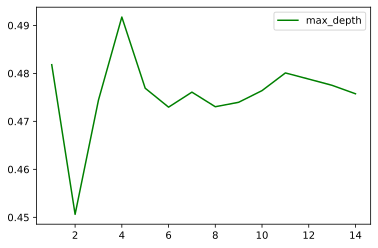

In [39]:
history = {'param':[], 'auc':[], 'f1_score':[], 'epohs':[]}

for i in range (1, 15):
    param_value=i
    rf = xgb.XGBRFClassifier(n_estimators=34, max_depth=param_value, learning_rate=0.3, verbosity=1, objective='binary:logistic',
                             gamma=19, min_child_weight=0, max_delta_step=3, subsample=0.8, colsample_bynode=0.9, colsample_bylevel=0.9,
                             reg_lambda=0.2, reg_alpha=0, use_label_encoder=False)
    rf.fit(X_resample, y_resample, eval_metric=['auc','logloss'])
    y_pred = rf.predict(X_val)

    print(f'{param_value} f1_score: {f1_score(y_val, y_pred, average="binary")}')

    history['param'].append(param_value)
    history['f1_score'].append(f1_score(y_val, y_pred, average='binary'))
    history['auc'].append(roc_auc_score(y_val, y_pred))
    
start = 0
plt.clf()
epochs = history['param'][start:]#
plt.plot(epochs, history['f1_score'][start:], 'g', label='max_depth')
plt.legend()
plt.show()

0.1 f1_score: 0.5019305019305019
0.2 f1_score: 0.5005065856129687
0.30000000000000004 f1_score: 0.5139664804469274
0.4 f1_score: 0.4933920704845815
0.5 f1_score: 0.5067873303167421
0.6000000000000001 f1_score: 0.504424778761062
0.7000000000000001 f1_score: 0.5023041474654378
0.8 f1_score: 0.48752834467120193
0.9 f1_score: 0.4725643896976483
1.0 f1_score: 0.48275862068965514
1.1 f1_score: 0.4729729729729729
1.2000000000000002 f1_score: 0.46818181818181814
1.3 f1_score: 0.4843049327354261
1.4000000000000001 f1_score: 0.47874720357941836


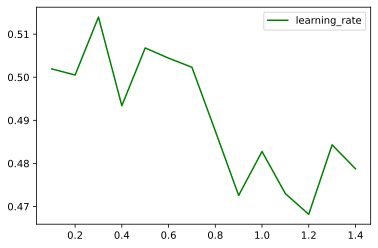

In [40]:
history = {'param':[], 'auc':[], 'f1_score':[], 'epohs':[]}

for i in range (1, 15):
    #param_value=0.001*(2**i)
    param_value=i*0.1
    model = RUSBoostClassifier(n_estimators=40, learning_rate=param_value, algorithm='SAMME.R', sampling_strategy='auto', replacement=False, random_state=None)
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_val)

    print(f'{param_value} f1_score: {f1_score(y_val, y_pred, average="binary")}')
    history['param'].append(param_value)
    history['f1_score'].append(f1_score(y_val, y_pred, average='binary'))
    history['auc'].append(roc_auc_score(y_val, y_pred))
    
start = 0
plt.clf()
epochs = history['param'][start:]#
plt.plot(epochs, history['f1_score'][start:], 'g', label='learning_rate')
plt.legend()
plt.show()

10 f1_score: 0.4211920529801324
20 f1_score: 0.43818849449204406
30 f1_score: 0.46594982078853053
40 f1_score: 0.4646706586826348
50 f1_score: 0.4940898345153665
60 f1_score: 0.5
70 f1_score: 0.4489311163895487
80 f1_score: 0.4813084112149533
90 f1_score: 0.4888888888888888
100 f1_score: 0.4976958525345623
110 f1_score: 0.4832369942196532
120 f1_score: 0.49590643274853796
130 f1_score: 0.4864864864864864
140 f1_score: 0.4711211778029445


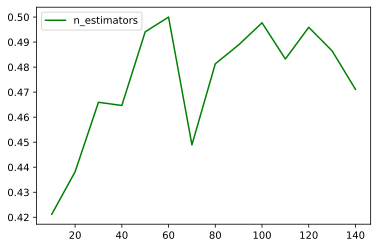

In [41]:
history = {'param':[], 'auc':[], 'f1_score':[], 'epohs':[]}

for i in range (1, 15):
    #param_value=0.001*(2**i)
    param_value=i*10
    model = BalancedRandomForestClassifier(n_estimators=param_value, criterion='gini', max_depth=None, min_samples_split=2, 
                                           min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                                           max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                           sampling_strategy='auto', replacement=False, n_jobs=None, random_state=None, 
                                           verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_val)

    print(f'{param_value} f1_score: {f1_score(y_val, y_pred, average="binary")}')
    history['param'].append(param_value)
    history['f1_score'].append(f1_score(y_val, y_pred, average='binary'))
    history['auc'].append(roc_auc_score(y_val, y_pred))
    
start = 0
plt.clf()
epochs = history['param'][start:]#
plt.plot(epochs, history['f1_score'][start:], 'g', label='n_estimators')
plt.legend()
plt.show()


We'll evaluate on the test set to see if the prediction has improved and by how much.

In [42]:
models = []
models.append(('RF', xgb.XGBRFClassifier(eval_metric=['auc','logloss'], use_label_encoder=False)))
models.append(('RF2', xgb.XGBRFClassifier(n_estimators=34, max_depth=8, learning_rate=0.3, verbosity=1, objective='binary:logistic',
                             gamma=19, min_child_weight=0, max_delta_step=3, subsample=0.8, colsample_bynode=0.9, colsample_bylevel=0.9,
                             reg_lambda=0.2, reg_alpha=0, eval_metric=['auc','logloss'], use_label_encoder=False)))

for name, model in models:
    model.fit(X_resample, y_resample)
    y_pred = model.predict(X_test)

    print(f'{name}: {f1_score(y_test, y_pred, average="binary")}')
    print(confusion_matrix(y_test, y_pred))
    
models = []
models.append(('BRF',BalancedRandomForestClassifier()))
models.append(('BRF2',BalancedRandomForestClassifier(n_estimators=param_value, criterion='gini', max_depth=None, min_samples_split=2, 
                                           min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                                           max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                           sampling_strategy='auto', replacement=False, n_jobs=None, random_state=None, 
                                           verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)))
models.append(('ADA', RUSBoostClassifier()))
models.append(('ADA2', RUSBoostClassifier(n_estimators=40, learning_rate=0.6, algorithm='SAMME.R', sampling_strategy='auto', replacement=False, random_state=None)))

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f'{name}: {f1_score(y_test, y_pred, average="binary")}')
    print(confusion_matrix(y_test, y_pred))

RF: 0.47884788478847884
[[655 438]
 [141 266]]
RF2: 0.48228176318063953
[[622 471]
 [128 279]]
XGB: 0.399002493765586
[[858 235]
 [247 160]]
XGB: 0.4898336414048059
[[683 410]
 [142 265]]
BRF: 0.4934579439252337
[[694 399]
 [143 264]]
BRF2: 0.4750235626767202
[[691 402]
 [155 252]]
ADA: 0.47565543071161054
[[686 407]
 [153 254]]
ADA2: 0.5043782837127846
[[646 447]
 [119 288]]


AdaBoost performed the best, so we'll use it for prediction.